# 説明
- asinから、レビュー関連情報（平均レーティング、レビュー件数）を取得
- amazonAPIでは、上記情報のサポートをやめたため、APIより得られるレビューページURLよりウェブスクラッピングで情報を取得
- エラーが頻発するので、同じプログラムを繰り返し実施する。最大10回

In [1]:
%matplotlib inline
from amazon.api import AmazonAPI
import requests
import pandas as pd
import numpy as np
import time
from bs4 import BeautifulSoup
import csv

In [2]:
data = pd.read_csv("amazon_smart_watch.csv",index_col="asin")

In [3]:
f = open("/home/kyohei/amazon_rootkey/rootkey.csv","r")
rootkey = list(csv.reader(f))
access,secret = rootkey
AMAZON_ACCESS_KEY = access[0].replace("AWSAccessKeyId=","")
AMAZON_SECRET_KEY = secret[0].replace("AWSSecretKey=","")
AMAZON_ASSOC_TAG = "kyoheikoga04-22"
amazon = AmazonAPI(AMAZON_ACCESS_KEY,AMAZON_SECRET_KEY,AMAZON_ASSOC_TAG,region="JP")

In [4]:
review_data = []
for i in range(10):
    if i >= 1:
        if len(error_data) == 0:
            break
    
    if i == 0:
        asins = data.index
    else:
        asins = error_data
    
    error_data = []
    for asin in asins:
        try:
            product = amazon.lookup(ItemId=asin)
            time.sleep(1.0)
            if product.reviews[0]:
                response = requests.get(product.reviews[1])
                time.sleep(1.0)
                parser = BeautifulSoup(response.content,"html.parser")
                result = parser.find_all('a',target='_top')
                try:
                    response = requests.get(result[len(result)-1].get('href'))
                    time.sleep(1.0)
                    parser = BeautifulSoup(response.content,'html.parser')
                    rate = parser.find_all(class_="a-row averageStarRatingNumerical")[0].span.text[6:]
                    number = parser.find_all(class_="a-size-medium a-text-beside-button totalReviewCount")[0].text
                    review_data.append([asin,rate,number,product.reviews[1]])
                except Exception:
                    product = amazon.lookup(ItemId=asin)
            else:
                review_data.append([asin,0,0,product.reviews[1]])
                time.sleep(1.0)
        except Exception:
            error_data.append(asin)
            time.sleep(1.0)

In [6]:
data_rev = pd.DataFrame(review_data,columns=["asin","average_rate","num_of_rate","review_url"])
data_rev = data_rev.set_index("asin",drop=True)
data_rev.to_csv("review_data.csv")

In [7]:
data_rev["average_rate"] = data_rev["average_rate"].astype(float)
data_rev["num_of_rate"] = data_rev["num_of_rate"].astype(float)

# レビュー件数の分布

データ個数：608
左rateのある割合:0.28
中5件以上rateのある割合:0.14
右10件以上rateのある割合:0.09


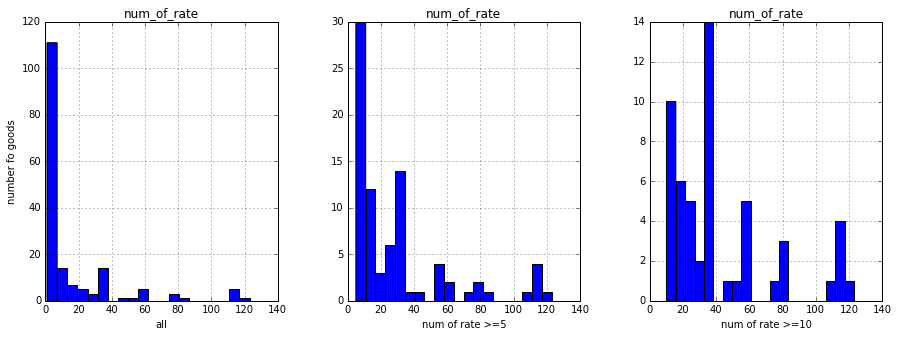

In [17]:
import matplotlib.pyplot as plt
print("データ個数：%d") %data_rev.shape[0]
print("左rateのある割合:%0.2f") %(data_rev[data_rev["num_of_rate"]>0].shape[0] / float(data_rev.shape[0]))
print("中5件以上rateのある割合:%0.2f") %(data_rev[data_rev["num_of_rate"]>4].shape[0] / float(data_rev.shape[0]))
print("右10件以上rateのある割合:%0.2f") %(data_rev[data_rev["num_of_rate"]>9].shape[0] / float(data_rev.shape[0]))

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)
data_rev[data_rev["num_of_rate"]>0].hist("num_of_rate",bins=20,ax=ax1)
data_rev[data_rev["num_of_rate"]>4].hist("num_of_rate",bins=20,ax=ax2)
data_rev[data_rev["num_of_rate"]>9].hist("num_of_rate",bins=20,ax=ax3)
ax1.set(ylabel="number fo goods",xlabel="all")
ax2.set(xlabel="num of rate >=5")
ax3.set(xlabel="num of rate >=10")
plt.show()

In [20]:
print("レビュー件数の統計量（全体）")
print data_rev["num_of_rate"].describe()
print("\nレビュー件数の統計量（rate有）")
print(data_rev[data_rev["num_of_rate"]>0]["num_of_rate"].describe())

レビュー件数の統計量（全体）
count    608.000000
mean       4.309211
std       15.109478
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max      123.000000
Name: num_of_rate, dtype: float64

レビュー件数の統計量（rate有）
count    171.000000
mean      15.321637
std       25.405339
min        1.000000
25%        2.000000
50%        4.000000
75%       16.000000
max      123.000000
Name: num_of_rate, dtype: float64


# 平均評点の分布

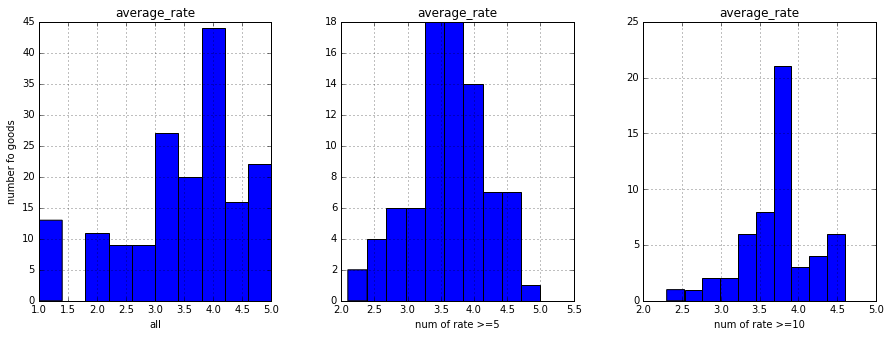

In [10]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)
data_rev[data_rev["average_rate"]>0].hist("average_rate",ax=ax1)
data_rev[(data_rev["average_rate"]>0) & (data_rev["num_of_rate"]>4)].hist("average_rate",ax=ax2)
data_rev[(data_rev["average_rate"]>0) & (data_rev["num_of_rate"]>9)].hist("average_rate",ax=ax3)
ax1.set(ylabel="number fo goods",xlabel="all")
ax2.set(xlabel="num of rate >=5")
ax3.set(xlabel="num of rate >=10")
plt.show()

In [21]:
print("平均評点統計量（rate有）")
print(data_rev[data_rev["num_of_rate"]>0]["average_rate"].describe())
print("\n平均評点統計量（rate5件以上）")
print(data_rev[(data_rev["average_rate"]>0) & (data_rev["num_of_rate"]>4)]["average_rate"].describe())
print("\n平均評点統計量（rate10件位上）")
print(data_rev[(data_rev["average_rate"]>0) & (data_rev["num_of_rate"]>9)]["average_rate"].describe())

平均評点統計量（rate有）
count    171.000000
mean       3.427485
std        1.050772
min        1.000000
25%        3.000000
50%        3.600000
75%        4.000000
max        5.000000
Name: average_rate, dtype: float64

平均評点統計量（rate5件以上）
count    83.000000
mean      3.633735
std       0.592489
min       2.100000
25%       3.300000
50%       3.800000
75%       3.900000
max       5.000000
Name: average_rate, dtype: float64

平均評点統計量（rate10件位上）
count    54.000000
mean      3.753704
std       0.474128
min       2.300000
25%       3.500000
50%       3.800000
75%       3.900000
max       4.600000
Name: average_rate, dtype: float64
